<a href="https://colab.research.google.com/github/kashtennyson/RailwayTrackCrackDetection/blob/main/Railway_Track_Crack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hyperparameters

image_shape = (256, 256)
batch_size = 16
epochs = 40
weight_decay = 0.001
learning_rate = 0.0001

In [2]:
#installing dependencies

!pip install split-folders

In [3]:
#importing modules

import os
import sys
import numpy as np
import pandas as pd
import splitfolders

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Lambda, Dense , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Flatten, Dense

In [4]:
#setting up matplotlib and its attributes

#importing style
plt.style.use('seaborn')

#setting up rc settings
mpl.rcParams['axes.grid'] = False
mpl.rcParams['lines.linewidth'] = 0.7
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.figsize'] = 8, 5

<ipython-input-4-4a536b2da8c8>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [5]:
#setting up google drive

#mounting drive
from google.colab import drive
drive.mount('/content/drive')

#appending drive's path to system
sys.path.append('/content/drive/MyDrive')

Mounted at /content/drive


In [6]:
#copying the dataset folder into the colab environment

!cp -r /content/drive/MyDrive/Productathon_AI/Classes /content

In [7]:
#splitting up the data in train, validation, and test directories

source_path='/content/Classes'

splitfolders.ratio(source_path,
                   output='/content/dataset',
                   seed=1337,
                   ratio=(0.8, 0.1, 0.1),
                   group_prefix=None,
                   move=False)

train_path = '/content/dataset/train'
valid_path = '/content/dataset/val'
test_path = '/content/dataset/test'

Copying files: 858 files [00:00, 8685.03 files/s]


In [8]:
#initialising the data generators

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen=ImageDataGenerator(rescale=1./255)

test_datagen=ImageDataGenerator(rescale=1./255)

In [9]:
#creating the train, validation, and test datasets

train_set=train_datagen.flow_from_directory(train_path,
                                            target_size=image_shape,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=True)

valid_set=train_datagen.flow_from_directory(valid_path,
                                            target_size=image_shape,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

test_set=test_datagen.flow_from_directory(test_path,
                                          target_size=image_shape,
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

Found 684 images belonging to 7 classes.
Found 84 images belonging to 7 classes.
Found 90 images belonging to 7 classes.


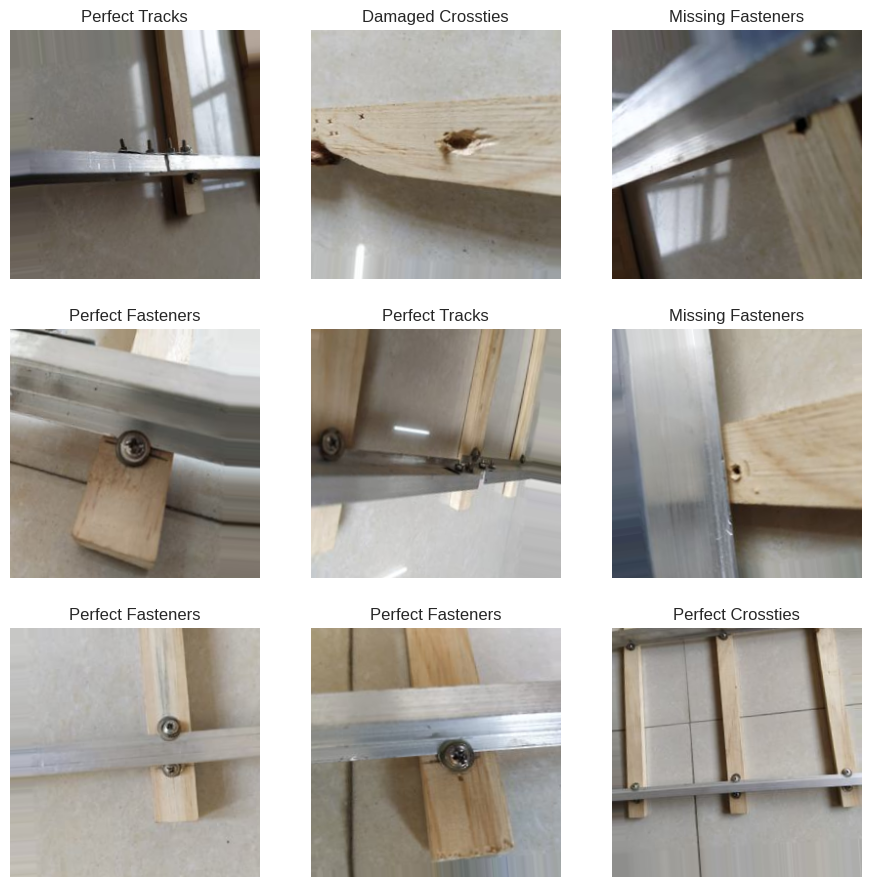

In [10]:
#visualizing different images in the train set/run this cell several times to see different images in the dataset

# Get a batch of images and labels from the generator
images, labels = train_set.next()

# Get class names
class_names = list(train_set.class_indices.keys())

# Display images and class names in a 9 x 9 grid
plt.figure(figsize=(11, 11))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i].argmax())])  # Display the class name as the title
    plt.axis('off')

plt.show()

In [11]:
#importing the pretrained inception v3 and initialising its attributes

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = ([256, 256] + [3]),
                                include_top = False,
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [12]:
#initialising the topmost layers of the pretrained inception v3

model = Sequential()
model.add(pre_trained_model)
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(7,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 batch_normalization_94 (Ba  (None, 6, 6, 2048)        8192      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                        

In [13]:
#compiling the model

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay )
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [14]:
#setting up callbacks

callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              min_delta=0,
                                              patience=10,
                                              verbose=0,
                                              mode='auto',
                                              baseline=None,
                                              restore_best_weights=True,
                                              start_from_epoch=0)

callback_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                  factor=0.1,
                                                  patience=4,
                                                  verbose=0,
                                                  mode='auto',
                                                  min_delta=0.001,
                                                  cooldown=0,
                                                  min_lr=1e-7)

In [15]:
#training the model

history=model.fit(train_set,
                  validation_data=valid_set,
                  epochs=epochs,
                  callbacks=[callback_1, callback_2])

Epoch 1/40
43/43 [==============================] - 33s 530ms/step - loss: 1.4018 - accuracy: 0.5906 - val_loss: 1.2983 - val_accuracy: 0.6548 - lr: 1.0000e-04
Epoch 2/40
43/43 [==============================] - 13s 309ms/step - loss: 0.6543 - accuracy: 0.8056 - val_loss: 0.6518 - val_accuracy: 0.7381 - lr: 1.0000e-04
Epoch 3/40
43/43 [==============================] - 13s 314ms/step - loss: 0.4642 - accuracy: 0.8363 - val_loss: 0.5979 - val_accuracy: 0.7619 - lr: 1.0000e-04
Epoch 4/40
43/43 [==============================] - 14s 315ms/step - loss: 0.3705 - accuracy: 0.8743 - val_loss: 0.4603 - val_accuracy: 0.8452 - lr: 1.0000e-04
Epoch 5/40
43/43 [==============================] - 13s 314ms/step - loss: 0.3302 - accuracy: 0.8947 - val_loss: 0.4269 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 6/40
43/43 [==============================] - 13s 313ms/step - loss: 0.2795 - accuracy: 0.9167 - val_loss: 0.5547 - val_accuracy: 0.8214 - lr: 1.0000e-04
Epoch 7/40
43/43 [======================

In [16]:
#registering some values from the trained model

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(len(accuracy))

Text(0.5, 1.0, 'Accuracy and Validation Accuracy')

<Figure size 600x300 with 0 Axes>

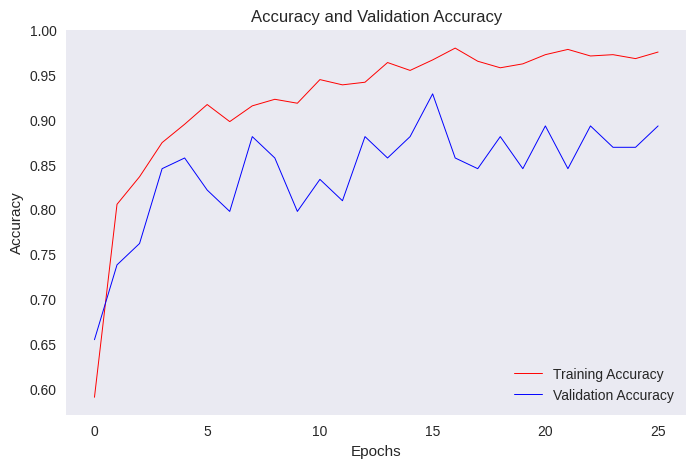

In [17]:
#plotting training and validation accuracy

plt.figure(figsize=(6, 3))
fig1, ax1 = plt.subplots()
ax1.plot(epochs, accuracy, 'r', label='Training Accuracy')
ax1.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([min(plt.ylim()),1])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Validation Accuracy')

Text(0.5, 1.0, 'Loss and Validation Loss')

<Figure size 600x300 with 0 Axes>

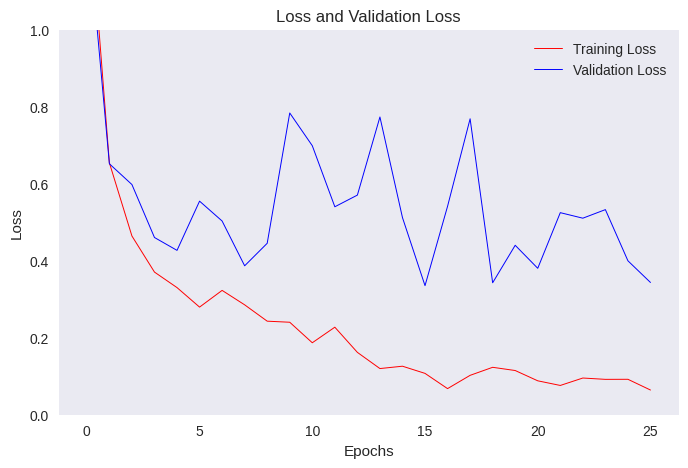

In [18]:
#plotting training and validation loss

plt.figure(figsize=(6, 3))
fig2, ax2 = plt.subplots()
ax2.plot(epochs, loss, 'r', label='Training Loss')
ax2.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0,1.0])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss and Validation Loss')

In [19]:
#evaluating the model on the test dataset

result = model.evaluate(test_set)
print("Test Loss:", result[0])
print("Test Accuracy:", result[1])

6/6 [==============================] - 2s 436ms/step - loss: 0.3865 - accuracy: 0.8889
Test Loss: 0.3865141272544861
Test Accuracy: 0.8888888955116272


6/6 [==============================] - 2s 64ms/step


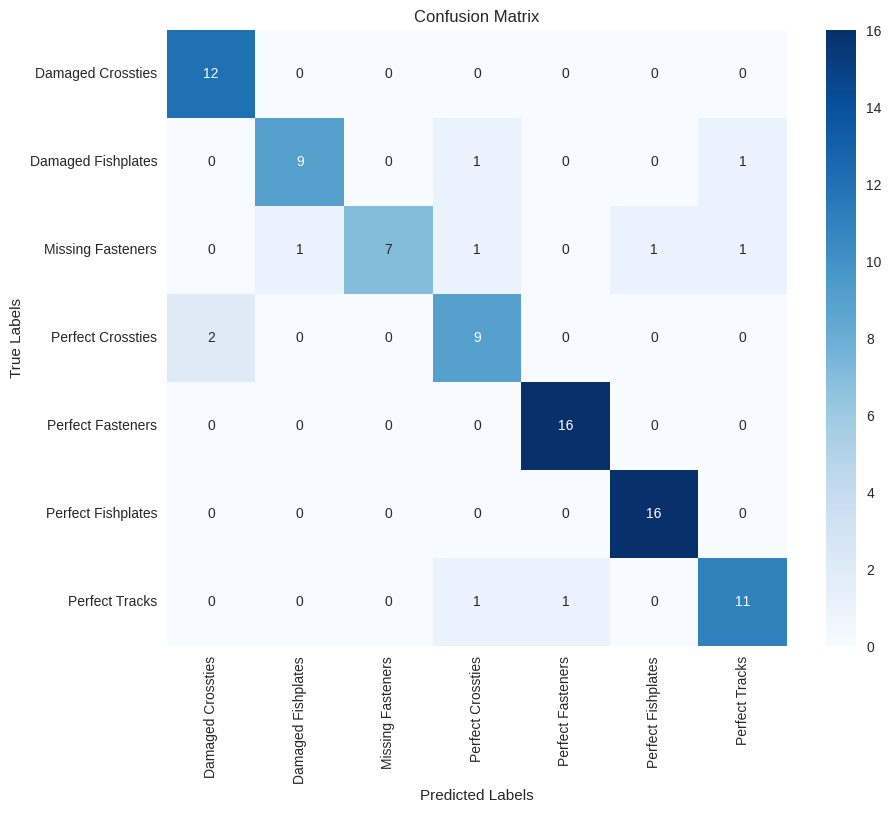

In [20]:
#comparing predicted and true labels/rendering the confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test set
predictions = model.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Get class names
class_names = list(test_set.class_indices.keys())

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [21]:
#saving the model in google drive

model.save('/content/drive/MyDrive/Productathon_AI/Models/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
